# 분석 목적 : 칼로리 소모량 예측

## 1. 라이브러리 및 데이터

In [1]:
# 필수 라이브러리리
import pandas as pd
import numpy as np
from scipy import stats

# 랜덤시드 고정
import random
import os

# 시각화 및 전처리
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 머신러닝 단일모형 알고리즘
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense

# 평가지표
from sklearn.metrics import r2_score,mean_squared_error

# 모델 및 가중치 저장
from tensorflow.python.keras.models import load_model

In [2]:
def seed_everything(seed: int = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(seed=42) # Seed 고정

In [3]:
# 데이터 불러오기
train = pd.read_csv('C:/Users/gksxk\statistics/2023-CBNU-machine-learning-main/Chapter_1/Regression/PSC/train.csv')
test = pd.read_csv('C:/Users/gksxk\statistics/2023-CBNU-machine-learning-main/Chapter_1/Regression/PSC/test.csv')
submission = pd.read_csv('C:/Users/gksxk\statistics/2023-CBNU-machine-learning-main/Chapter_1/Regression/PSC/sample_submission.csv') # 답안지 파일

## 2. 탐색적 자료분석(EDA)

### 1) 데이터 확인 및 단위 변환

In [4]:
train

,ID,Exercise_Duration,Body_Temperature(F),BPM,Height(Feet),Height(Remainder_Inches),Weight(lb),Weight_Status,Gender,Age,Calories_Burned
0,TRAIN_0000,26.0,105.6,107.0,5.0,9.0,154.3,Normal Weight,F,45,166.0
1,TRAIN_0001,7.0,103.3,88.0,6.0,6.0,224.9,Overweight,M,50,33.0
2,TRAIN_0002,7.0,103.3,86.0,6.0,3.0,218.3,Overweight,M,29,23.0
3,TRAIN_0003,17.0,104.0,99.0,5.0,6.0,147.7,Normal Weight,F,33,91.0
4,TRAIN_0004,9.0,102.7,88.0,5.0,10.0,169.8,Normal Weight,M,38,32.0
...,...,...,...,...,...,...,...,...,...,...,...
7495,TRAIN_7495,22.0,105.1,104.0,4.0,10.0,112.4,Normal Weight,F,75,151.0
7496,TRAIN_7496,20.0,105.3,104.0,5.0,8.0,147.7,Normal Weight,F,21,114.0
7497,TRAIN_7497,8.0,103.1,90.0,6.0,2.0,202.8,Overweight,M,57,41.0
7498,TRAIN_7498,12.0,104.4,97.0,5.0,9.0,167.6,Overweight,M,35,57.0


train 자료는 7500개의 데이터와 11개의 변수를 가진다.

In [5]:
test

,ID,Exercise_Duration,Body_Temperature(F),BPM,Height(Feet),Height(Remainder_Inches),Weight(lb),Weight_Status,Gender,Age
0,TEST_0000,26.0,105.1,107.0,5.0,1.0,114.6,Normal Weight,F,45
1,TEST_0001,29.0,104.9,111.0,6.0,2.0,198.4,Overweight,M,21
2,TEST_0002,11.0,104.0,90.0,5.0,9.0,169.8,Normal Weight,M,58
3,TEST_0003,24.0,105.4,108.0,5.0,12.0,196.2,Overweight,M,35
4,TEST_0004,29.0,106.0,116.0,5.0,7.0,147.7,Normal Weight,F,67
...,...,...,...,...,...,...,...,...,...,...
7495,TEST_7495,28.0,105.6,106.0,5.0,12.0,178.6,Normal Weight,M,51
7496,TEST_7496,4.0,102.0,84.0,5.0,10.0,183.0,Overweight,M,25
7497,TEST_7497,24.0,105.1,97.0,5.0,2.0,130.1,Normal Weight,F,42
7498,TEST_7498,8.0,103.1,83.0,5.0,5.0,134.5,Normal Weight,F,48


test 자료는 7500개의 데이터와 10개의 변수를 가진다.

#### train, test 공통 변수
* ID : 샘플 별 고유 id
* Exercise_Duration  : 운동 시간(분)
* Body_Temperature(F) : 체온
* BPM : 심박수
* Height(Feet) : 키(피트)
* Height(Remainder_Inches) : 키(피트 계산 후 더해야 할 키)
* Weight(lb) : 몸무게(파운드)
* Weight_Status : 체중 상태
* Gender : 성별
* Age : 나이

#### train에만 존재하는 변수
* Calories_Burned : 칼로리 소모량(목표 예측값)

#### 사용되지 않는 변수 제거

In [6]:
train.drop(columns="ID", inplace=True)
test.drop(columns="ID", inplace=True)

#### 변수의 단위 변경

In [7]:
train["Height"] = train.pop("Height(Feet)") * 30.48 + train.pop("Height(Remainder_Inches)") * 2.54
test["Height"] = test.pop("Height(Feet)") * 30.48 + test.pop("Height(Remainder_Inches)") * 2.54

train["Weight"] = train.pop("Weight(lb)") * 0.453592
test["Weight"] = test.pop("Weight(lb)") * 0.453592

train["Body_Temperature"] = (train.pop("Body_Temperature(F)") - 32) / 1.8
test["Body_Temperature"] = (test.pop("Body_Temperature(F)") - 32) / 1.8

1. 변수 Height(Feet), Height(Remainder_Inches)의 단위 Feet, Inches를 좀 더 익숙한 cm단위(Heigt)로 변경
2. 변수 Weight(lb)의 단위 를 1번과 같은 이유로 kg단위(Weight)로 변경
3. 변수 Body_Temperature(F)의 단위 F를 1번과 같은 이유로 C단위(Body_Temperature)로 변경

In [8]:
train.head()

,Exercise_Duration,BPM,Weight_Status,Gender,Age,Calories_Burned,Height,Weight,Body_Temperature
0,26.0,107.0,Normal Weight,F,45,166.0,175.26,69.989246,40.888889
1,7.0,88.0,Overweight,M,50,33.0,198.12,102.012841,39.611111
2,7.0,86.0,Overweight,M,29,23.0,190.50,99.019134,39.611111
3,17.0,99.0,Normal Weight,F,33,91.0,167.64,66.995538,40.000000
4,9.0,88.0,Normal Weight,M,38,32.0,177.80,77.019922,39.277778


### 2) 데이터 시각화

#### train, test 데이터의 자료형

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Exercise_Duration  7500 non-null   float64
 1   BPM                7500 non-null   float64
 2   Weight_Status      7500 non-null   object 
 3   Gender             7500 non-null   object 
 4   Age                7500 non-null   int64  
 5   Calories_Burned    7500 non-null   float64
 6   Height             7500 non-null   float64
 7   Weight             7500 non-null   float64
 8   Body_Temperature   7500 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 527.5+ KB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Exercise_Duration  7500 non-null   float64
 1   BPM                7500 non-null   float64
 2   Weight_Status      7500 non-null   object 
 3   Gender             7500 non-null   object 
 4   Age                7500 non-null   int64  
 5   Height             7500 non-null   float64
 6   Weight             7500 non-null   float64
 7   Body_Temperature   7500 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 468.9+ KB


train 데이터는 Weight_Status, Age가 명목형 변수이고, 그 외의 변수들은 연속형 변수이다.  
test 데이터 또한 Weight_Status, Age가 명목형 변수이고, 그 외의 변수들은 연속형 변수이다.

#### train 데이터의 기술통계량

In [11]:
train.describe()

,Exercise_Duration,BPM,Age,Calories_Burned,Height,Weight,Body_Temperature
count,7500.0000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,15.5012,95.498133,42.636000,89.373467,174.506128,75.006511,40.018652
std,8.3553,9.587331,16.883188,62.817086,14.318365,15.108304,0.784914
min,1.0000,69.000000,20.000000,1.000000,121.920000,36.015205,37.111111
25%,8.0000,88.000000,28.000000,35.000000,165.100000,63.003929,39.611111
50%,15.0000,95.000000,39.000000,77.000000,175.260000,73.980855,40.222222
75%,23.0000,103.000000,56.000000,138.000000,185.420000,86.998946,40.611111
max,30.0000,128.000000,79.000000,300.000000,218.440000,131.995272,41.500000


BPM, Age, Height, Weight의 변수의 min, max를 통해 이상치으로 추정되는 값들을 확인할 수 있다.

#### train 데이터의 명목형 자료의 범주별 Calories_Burned의 평균 시각화

Weight_Status

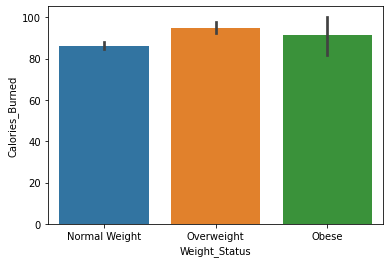

In [12]:
sns.barplot(x = train['Weight_Status'], y = train['Calories_Burned'])
plt.show()

Weight_Status 변수의 범주별 평균 비교에서 Overweight > Obeses > Normal 순으로 Calories_Burned의 평균값이 큰 것을 확인할 수 있다.  
세 집단(범주) 간에 차이가 있을 것으로 생각된다.

Gender

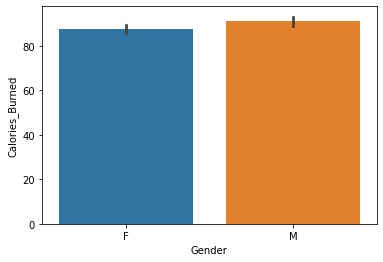

In [13]:
sns.barplot(x = train['Gender'], y = train['Calories_Burned'])
plt.show()

Gender 변수의 범주별 평균 비교에서 M > F 순으로 Calories_Burned의 평균값이 큰 것을 확인할 수 있다.  
그러나 평균 차이가 근소하므로, 두 집단(범주) 간의 차이가 없을 것으로 생각된다.

#### train 데이터의 밀도함수 확인

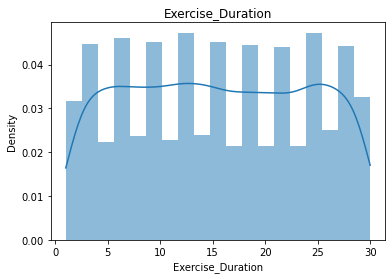

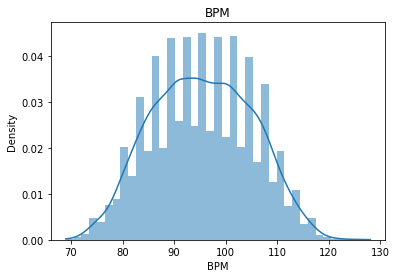

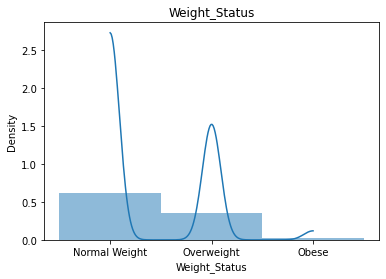

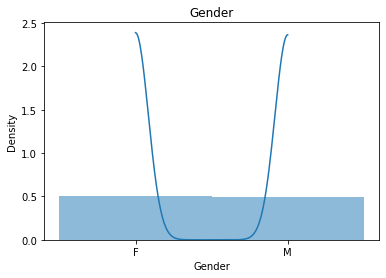

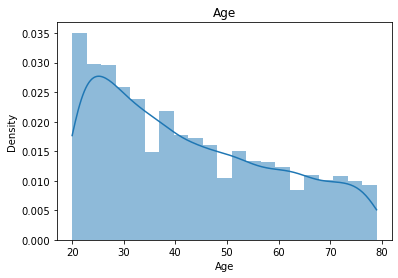

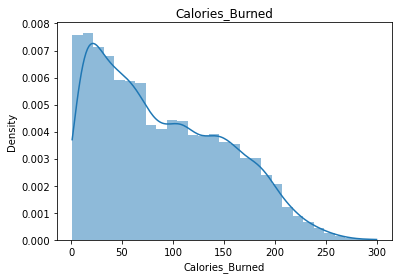

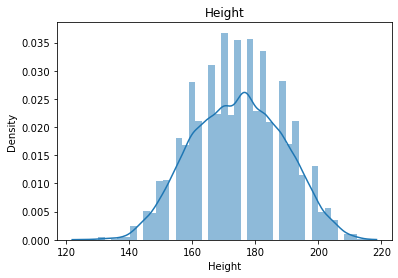

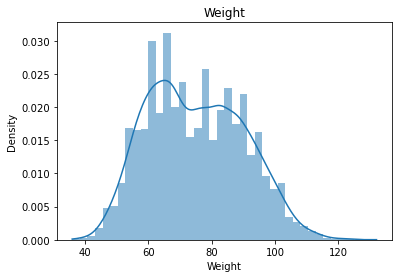

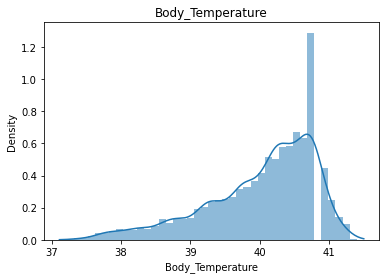

In [14]:
for col in train.columns:
    sns.histplot(train[col], kde=True, stat="density", linewidth=0)
    plt.title(col)
    plt.show()

연속형 변수의 분포를 확인했을 때, 나이(Age), 체온(Body_Temperature), 칼로리 소모량(Calories_Burned)의 분포는 종 모양과는 거리가 멀다.  
따라서 위의 3개의 변수는 변수변환을 통해 정규분포와 비슷하게 만들어주는 것이 적절해 보인다.  
그러나 분포의 모형이 종 모양과 가장 거리가 먼 Age 변수에 대해서만 변수변환을 적용할 것이다.(Calories_Burned은 목표변수이므로 생략)

#### train 데이터의 목표변수와의 산점도 확인

성별에 따라(hue=Gender)

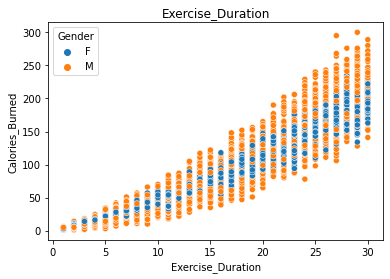

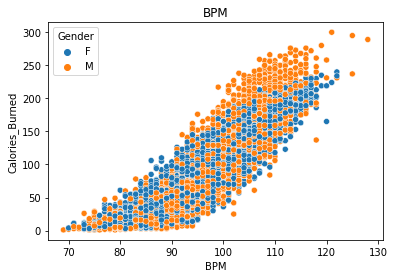

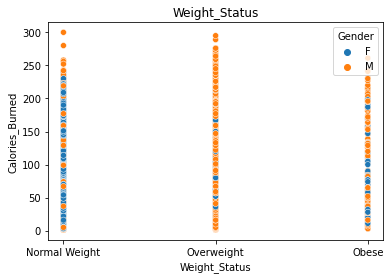

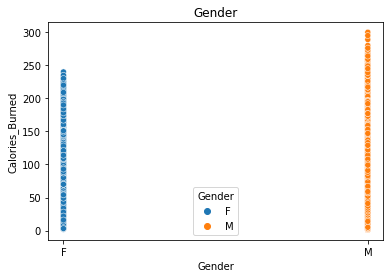

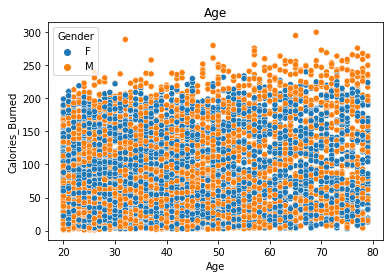

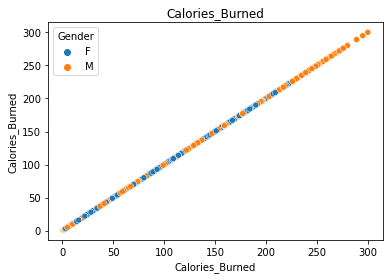

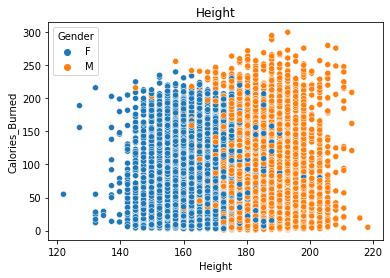

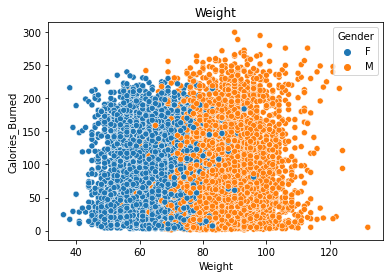

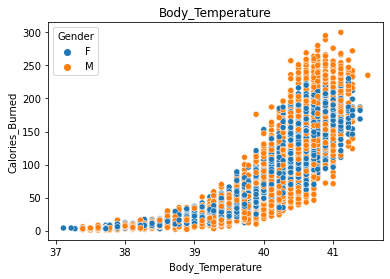

In [15]:
for col in train.columns:
    sns.scatterplot(x=train[col], y=train["Calories_Burned"], hue=train["Gender"], data=train)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Calories_Burned")
    plt.show()

몸무게 상태에 따라(hue=Weight_Status)

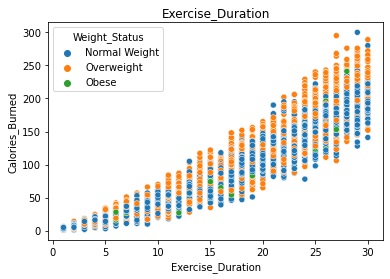

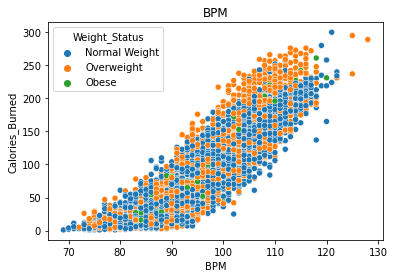

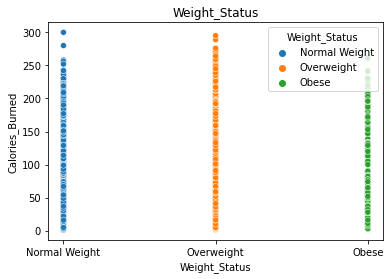

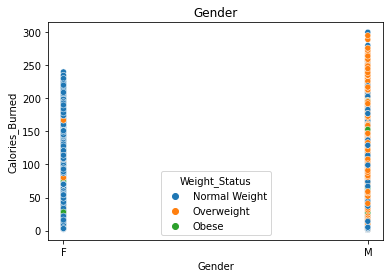

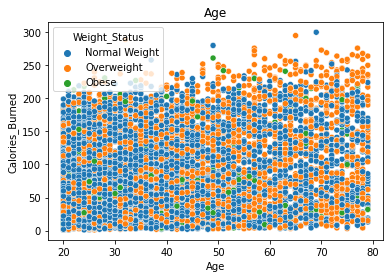

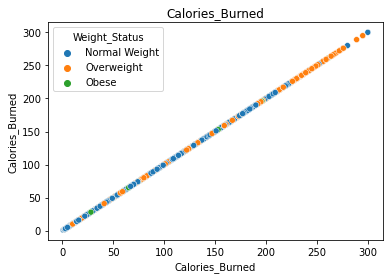

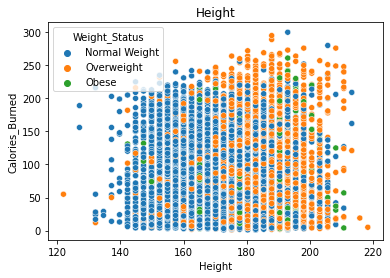

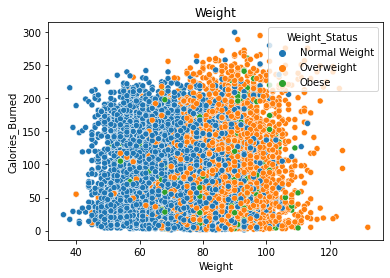

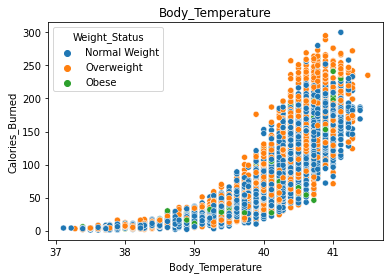

In [16]:
for col in train.columns:
    sns.scatterplot(x=train[col], y=train["Calories_Burned"], hue=train["Weight_Status"], data=train)
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel("Calories_Burned")
    plt.show()

#### 성별에 따른 산점도  

* Exercise_Duration, BPM, Body_Temperature가 목표변수 Calories_Burned과 강한 양의 상관관계를 가질 것으로 추측할 수 있다.
* Weight_status에서 Normal Weight는 여자(F)가, Overweight, Obese에서는 남자(M)가 확연히 많이 나타났다.
* 에상과 달리, Weight가 높을수록, Calories_Burned이 높은 것은 아니었다. 오히려 상관관계가 거의 없는 것으로 추측된다.
* 그러나 같은 운동시간(Exercise_Duration) 대비 과체중(Overweight)이거나 비만(Obese)인 사람의 칼로리 소모량(Calories_Burned)이 높게 나타났다.  


#### 몸무게 상태에 따른 산점도  

* Normal Weight를 여성(F), Overweight, Obese를 남성(M)으로 가정하고, 분석을 하면 성별에 따른 산점도와 유사한 결과를 얻을 수 있다.

#### train 데이터의 연속형 변수 상관관계 확인

<AxesSubplot:>

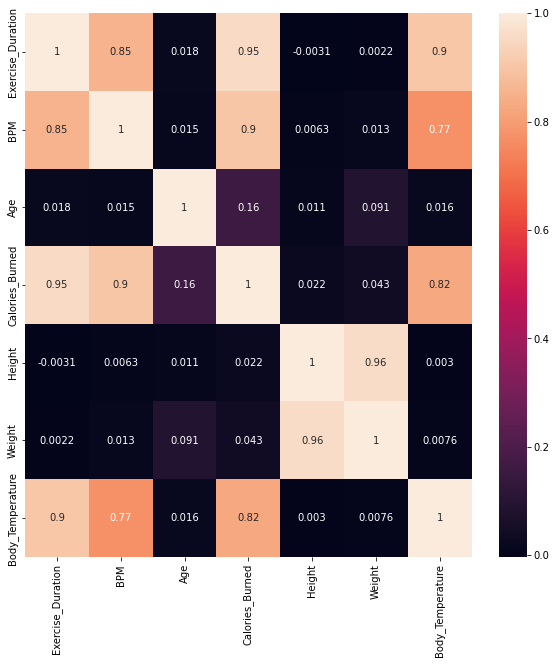

In [17]:
plt.figure(figsize=(10, 10))
sns.heatmap(train.corr(),annot=True)

연속형 변수와 목표변수인 Calories_Burned와 강한 (양의)상관관계는 Exercise_Duration(0.95) > BPM(0.9) > Body_Temperature(0.82)가 나타낸다.  
그 외의 연속형 변수들 Age(0.16), Height(0.022), Weight(0.043)의 상관관계는 매우 낮은 상관계수를 가지므로, 상관관계가 거의 없는 것으로 판단할 수 있다.  
  
목표변수를 제외한, 연속형 변수 간 상관관계를 확인했을 때, Exercise_Duration, BPM, Body_Temperature가 서로 간에 다중공선성을 가질 것으로 추측되고, Weight와 Height 또한 다중공선성을 가질 것으로 추측된다.
자세한 것은 분산확대인자(VIF)로 확인 가능하고 제거 유무를 결정할 수 있다. 이는 사용할 모델에 따라 변수선택이 결정될 수 있다.  
모델링 과정에서 딥러닝 신경망을 사용할 것이므로, 다중공선성이 존재하는 변수들을 제거하지 않을 것이다. 일반적으로 신경망 모형에서는 다중공선성이 존재하는 변수들을 포함하는 것이 좋은 성능으로 나타나기 때문이다.

#### train 데이터의 범주형 자료의 연관성 확인

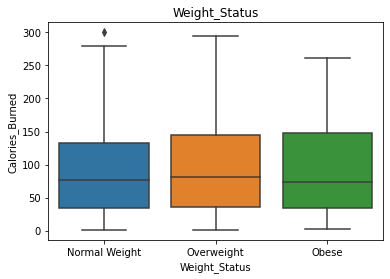

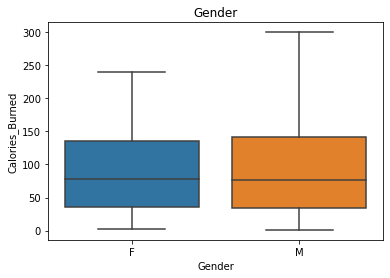

In [18]:
categoric_features=["Weight_Status", "Gender"]
train_categoric=train[categoric_features]

for col in categoric_features:
    sns.boxplot(x=train[col], y=train["Calories_Burned"])
    plt.title(col)
    plt.show()

몸무게 상태와 성별에 따라 각각의 사분위 수 범위의 큰 차이는 없지만, 분산의 차이는 존재한다.  
몸무게 상태를 더 정밀하게 나타내기 위해 수치형 변수인 BMI로 대체할 수 있을 것이다.

### 3) EDA를 통해 얻은 주요 insight  

- 운동 시간(Exercise_Duration), 체온(Body_Temperature), BPM끼리는 강한 양의 상관관계를 가진다

- 이들은 또한 칼로리 소모량과(Calories_Burned)도 강한 양의 상관관계를 가진다

- 키(Height)와 몸무게(Weight)는 강한 양의 상관관계를 가진다

- 키(Height)와 몸무게(Weight), 칼로리 소모량(Calories_Burned) 사이에는 상관관계가 존재하지 않는다

- 같은 운동시간(Exercise_Duration) 대비 과체중(Overweight)이거나 비만(Obese)인 사람의 칼로리 소모량(Calories_Burned)이 높게 나타났다.  

- 나이(Age) 분포는 종모양과는 거리가 멀다. 따라서 변수변환을 적용하는 것이 적절해 보인다.

- 몸무게 상태(Weight_Status)를 더 정밀하게 나타낼 수 있는 파생변수인 BMI를 만들 수 있다

#### Age변수 변수변환(log변환) 및 파생변수 BMI 생성, 변수 Weight_Status 삭제

In [19]:
train["BMI"] = train["Weight"] / (train["Height"] / 100)**2
test["BMI"] = test["Weight"] / (test["Height"] / 100)**2

train.drop(columns="Weight_Status", inplace=True)
test.drop(columns="Weight_Status", inplace=True)

train["Age"] = np.log(train["Age"])
test["Age"] = np.log(test["Age"])

In [20]:
train.head()

,Exercise_Duration,BPM,Gender,Age,Calories_Burned,Height,Weight,Body_Temperature,BMI
0,26.0,107.0,F,3.806662,166.0,175.26,69.989246,40.888889,22.785874
1,7.0,88.0,M,3.912023,33.0,198.12,102.012841,39.611111,25.989517
2,7.0,86.0,M,3.367296,23.0,190.50,99.019134,39.611111,27.285327
3,17.0,99.0,F,3.496508,91.0,167.64,66.995538,40.000000,23.839140
4,9.0,88.0,M,3.637586,32.0,177.80,77.019922,39.277778,24.363493


# 3. 데이터 전처리(Reprocessing)

#### 독립변수, 종속변수(목표변수)로 나누기

In [21]:
train_x = train.drop(['Calories_Burned'], axis = 1)
train_y = train['Calories_Burned']
test_x = test

#### Label Encoding 방법

In [22]:
ordinal_features = ['Gender']

for feature in ordinal_features:
    le = LabelEncoder()
    le = le.fit(train_x[feature])
    train_x[feature] = le.transform(train_x[feature])

    for label in np.unique(test_x[feature]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)
    test_x[feature] = le.transform(test_x[feature])

In [23]:
train_x.head()

,Exercise_Duration,BPM,Gender,Age,Height,Weight,Body_Temperature,BMI
0,26.0,107.0,0,3.806662,175.26,69.989246,40.888889,22.785874
1,7.0,88.0,1,3.912023,198.12,102.012841,39.611111,25.989517
2,7.0,86.0,1,3.367296,190.50,99.019134,39.611111,27.285327
3,17.0,99.0,0,3.496508,167.64,66.995538,40.000000,23.839140
4,9.0,88.0,1,3.637586,177.80,77.019922,39.277778,24.363493


명목형 자료인 Gender에 대해서, 데이터 분석이 가능하게 하기 위해서 Label Encoding 방법을 이용해 수치화를 진행하였다.

### 1) 결측치 대체

결측치는 존재하지 않는다.

### 2) 이상치 제거

#### 독립변수들의 Z-score 기반 이상치 제거(ESD 검출)

In [24]:
X=train_x
y=train_y

z_scores = np.abs(stats.zscore(X))
X_clean = X[(z_scores < 3).all(axis=1)]
y_clean = y[X_clean.index]

In [25]:
X_clean.shape

(7447, 8)

Z-score 기반의 이상치 제거로 인해 53개의 자료가 제거되었다.  
보다 보편적이고, 일반적인 모델의 적합을 위해 각 독립변수의 평균으로부터 3 표준편차 떨어진 97% 범위만을 대상으로 데이터셋을 구성하고자 했다.  
따라서 그 범위 이외의 값들은 작위적으로 이상치로 판단하였다. 그러므로 97% 이외의 값은 Z-score를 이용한 ESD로 이상치를 제거하였다.

### 3) 분석변수 처리

#### 독립변수들의 표준화(Scaling)

In [26]:
numeric_col=X.columns.drop(["Gender"])
numeric_col

Index(['Exercise_Duration', 'BPM', 'Age', 'Height', 'Weight',
       'Body_Temperature', 'BMI'],
      dtype='object')

In [27]:
scaler = StandardScaler()

X_clean[numeric_col]= scaler.fit_transform(X_clean[numeric_col])
X_train_scaled=X_clean
y_train=y_clean

test_x[numeric_col]= scaler.transform(test_x[numeric_col])
X_test_scaled=test_x

C:\Users\gksxk\AppData\Local\Temp\ipykernel_14844\2543900962.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_clean[numeric_col]= scaler.fit_transform(X_clean[numeric_col])


#### 스케일링 된 train 자료의 인덱스 재정렬

In [28]:
X_train_scaled=X_train_scaled.reset_index(drop=True)
X_train_scaled.head()

,Exercise_Duration,BPM,Gender,Age,Height,Weight,Body_Temperature,BMI
0,1.255544,1.200496,0,0.332746,0.054719,-0.331582,1.119893,-0.992170
1,-1.030822,-0.793000,1,0.595594,1.660413,1.801920,-0.547699,1.051487
2,-1.030822,-1.002841,1,-0.763363,1.125181,1.602471,-0.547699,1.878106
3,0.172528,0.361129,0,-0.441012,-0.480513,-0.531031,-0.040171,-0.320275
4,-0.790152,-0.793000,1,-0.089057,0.233129,0.136821,-0.982722,0.014219


#### train 자료의 종속변수(목표변수)의 인덱스 재정렬

In [29]:
y_train=pd.DataFrame(y_train)
y_train=y_train.reset_index(drop=True)
y_train.head()

,Calories_Burned
0,166.0
1,33.0
2,23.0
3,91.0
4,32.0


#### 스케일링 된 test 자료의 인덱스 재정렬

In [30]:
X_test_scaled.head()

,Exercise_Duration,BPM,Gender,Age,Height,Weight,Body_Temperature,BMI
0,1.255544,1.200496,0,0.332746,-1.372565,-1.531299,0.757373,-1.714696
1,1.616549,1.620179,1,-1.568601,0.946771,1.001101,0.612365,0.721846
2,-0.549482,-0.583158,1,0.965864,0.054719,0.136821,-0.040171,0.467973
3,1.014873,1.305417,1,-0.294220,0.589950,0.934618,0.974885,1.446799
4,1.616549,2.144783,0,1.325731,-0.302102,-0.531031,1.409909,-0.770839


# 4. 모델링(modeling)

### 1) 인공신경망 적합 및 평가

학습률(ir=0.0001), epochs= 3000, batch_size=32의 경우

In [31]:
initializer = tf.keras.initializers.GlorotUniform(seed=42)
model_swish = tf.keras.Sequential([
    tf.keras.layers.Dense(units=52, activation='swish', input_shape=(8,), kernel_initializer=initializer),
    tf.keras.layers.Dense(units=39, activation='swish', kernel_initializer=initializer),
    tf.keras.layers.Dense(units=26, activation='swish', kernel_initializer=initializer),
    tf.keras.layers.Dense(units=13, activation='swish', kernel_initializer=initializer),
    tf.keras.layers.Dense(units=1, kernel_initializer=initializer)
])
model_swish.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')

In [32]:
model_swish.fit(X_train_scaled, y_train, epochs=3000, batch_size=32, validation_split=0.2)

Epoch 1/3000
187/187 [==============================] - 1s 2ms/step - loss: 11856.3711 - val_loss: 12057.3320
Epoch 2/3000
187/187 [==============================] - 0s 1ms/step - loss: 11603.2080 - val_loss: 11563.4873
Epoch 3/3000
187/187 [==============================] - 0s 1ms/step - loss: 10494.3281 - val_loss: 9416.1006
Epoch 4/3000
187/187 [==============================] - 0s 1ms/step - loss: 7007.7231 - val_loss: 4540.1772
Epoch 5/3000
187/187 [==============================] - 0s 1ms/step - loss: 2454.5911 - val_loss: 1079.8806
Epoch 6/3000
187/187 [==============================] - 0s 1ms/step - loss: 714.5721 - val_loss: 541.8237
Epoch 7/3000
187/187 [==============================] - 0s 1ms/step - loss: 486.1677 - val_loss: 458.6661
Epoch 8/3000
187/187 [==============================] - 0s 1ms/step - loss: 423.4373 - val_loss: 410.6709
Epoch 9/3000
187/187 [==============================] - 0s 1ms/step - loss: 381.0338 - val_loss: 371.8053
Epoch 10/3000
187/187 [========

187/187 [==============================] - 0s 1ms/step - loss: 3.6646 - val_loss: 3.5682
Epoch 80/3000
187/187 [==============================] - 0s 1ms/step - loss: 3.6119 - val_loss: 3.4748
Epoch 81/3000
187/187 [==============================] - 0s 1ms/step - loss: 3.5612 - val_loss: 3.5532
Epoch 82/3000
187/187 [==============================] - 0s 1ms/step - loss: 3.4639 - val_loss: 3.4583
Epoch 83/3000
187/187 [==============================] - 0s 1ms/step - loss: 3.3118 - val_loss: 3.6676
Epoch 84/3000
187/187 [==============================] - 0s 2ms/step - loss: 3.2358 - val_loss: 3.1977
Epoch 85/3000
187/187 [==============================] - 0s 2ms/step - loss: 3.2075 - val_loss: 3.1099
Epoch 86/3000
187/187 [==============================] - 0s 2ms/step - loss: 3.1505 - val_loss: 3.0766
Epoch 87/3000
187/187 [==============================] - 0s 2ms/step - loss: 3.0390 - val_loss: 2.9360
Epoch 88/3000
187/187 [==============================] - 0s 1ms/step - loss: 2.9997 - v

187/187 [==============================] - 0s 1ms/step - loss: 0.7903 - val_loss: 0.8675
Epoch 159/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.7858 - val_loss: 0.8713
Epoch 160/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.8471 - val_loss: 0.8144
Epoch 161/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.7617 - val_loss: 0.7951
Epoch 162/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.7454 - val_loss: 0.8116
Epoch 163/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.7444 - val_loss: 0.8262
Epoch 164/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.7505 - val_loss: 0.8043
Epoch 165/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.7479 - val_loss: 0.7785
Epoch 166/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.7231 - val_loss: 0.7768
Epoch 167/3000
187/187 [==============================] - 0s 1ms/step - loss: 0

Epoch 237/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.3848 - val_loss: 0.4074
Epoch 238/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.3683 - val_loss: 0.4079
Epoch 239/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.3597 - val_loss: 0.3889
Epoch 240/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.3627 - val_loss: 0.3939
Epoch 241/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.3576 - val_loss: 0.4004
Epoch 242/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.3527 - val_loss: 0.3985
Epoch 243/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.3595 - val_loss: 0.3657
Epoch 244/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.3540 - val_loss: 0.3759
Epoch 245/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.3446 - val_loss: 0.3674
Epoch 246/3000
187/187 [==============================] - 0s 1ms

Epoch 316/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.2544 - val_loss: 0.2475
Epoch 317/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.2497 - val_loss: 0.3085
Epoch 318/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.2424 - val_loss: 0.2496
Epoch 319/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.2423 - val_loss: 0.2514
Epoch 320/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.2335 - val_loss: 0.2437
Epoch 321/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.2468 - val_loss: 0.2639
Epoch 322/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.2330 - val_loss: 0.2461
Epoch 323/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.2374 - val_loss: 0.2533
Epoch 324/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.2417 - val_loss: 0.3018
Epoch 325/3000
187/187 [==============================] - 0s 2ms

Epoch 395/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.1930 - val_loss: 0.1872
Epoch 396/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.1822 - val_loss: 0.1974
Epoch 397/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.1865 - val_loss: 0.1997
Epoch 398/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.1821 - val_loss: 0.2026
Epoch 399/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.1835 - val_loss: 0.2305
Epoch 400/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.1791 - val_loss: 0.1918
Epoch 401/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.1805 - val_loss: 0.2473
Epoch 402/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.1796 - val_loss: 0.2371
Epoch 403/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.1824 - val_loss: 0.1893
Epoch 404/3000
187/187 [==============================] - 0s 1ms

Epoch 474/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.1561 - val_loss: 0.1634
Epoch 475/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.1623 - val_loss: 0.1627
Epoch 476/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.1532 - val_loss: 0.1791
Epoch 477/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.1525 - val_loss: 0.1764
Epoch 478/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.1551 - val_loss: 0.1612
Epoch 479/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.1492 - val_loss: 0.1749
Epoch 480/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.1551 - val_loss: 0.1621
Epoch 481/3000
187/187 [==============================] - 0s 1ms/step - loss: 0.1504 - val_loss: 0.1536
Epoch 482/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.1456 - val_loss: 0.1528
Epoch 483/3000
187/187 [==============================] - 0s 2ms

Epoch 553/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.1332 - val_loss: 0.1506
Epoch 554/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.1421 - val_loss: 0.1644
Epoch 555/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.1352 - val_loss: 0.1535
Epoch 556/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.1351 - val_loss: 0.1409
Epoch 557/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.1341 - val_loss: 0.1472
Epoch 558/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.1327 - val_loss: 0.1537
Epoch 559/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.1342 - val_loss: 0.1407
Epoch 560/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.1392 - val_loss: 0.1490
Epoch 561/3000
187/187 [==============================] - 0s 2ms/step - loss: 0.1355 - val_loss: 0.1400
Epoch 562/3000
187/187 [==============================] - 0s 2ms

KeyboardInterrupt: 

학습률이 0.0001이고, epochs가 3000, batch_size가 32일 때, 은닉층 4개와 각각 52,39,26,13 노드를 가질 때 검증 데이터의가장  낮은 mse를 갖게 되었다.  
또한 활성화 함수는 swish함수로 다른 활성화 함수에 비해 성능이 현저히 증가하는 것을 확인할 수 있었다.

### 2) 가중치 저장

#### 가중치 저장(csv)

In [33]:
from keras.models import load_model
model_swish.save('../OUT/model_swish.h5')

In [34]:
new_model=tf.keras.models.load_model('../OUT/model_swish.h5')

# 5. 제출

### 신경망

In [35]:
preds = new_model.predict(X_test_scaled)
submission['Calories_Burned'] = preds
submission.to_csv('../DAT/submit_model_swish.csv', index = False)

235/235 [==============================] - 1s 3ms/step
